In [299]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Dependencies

In [300]:
from urls_list import * #where all urls and paths are saved
from config import *
from pymongo import MongoClient
import pandas as pd
import matplotlib
import missingno as msno
import numpy as np
from datetime import datetime
import requests
import re

In [313]:
client = MongoClient(db_connection_string)
records = list(client.ETLInsight["HistoricRental"].find({}, {'_id':0}))
DF = pd.DataFrame(records)

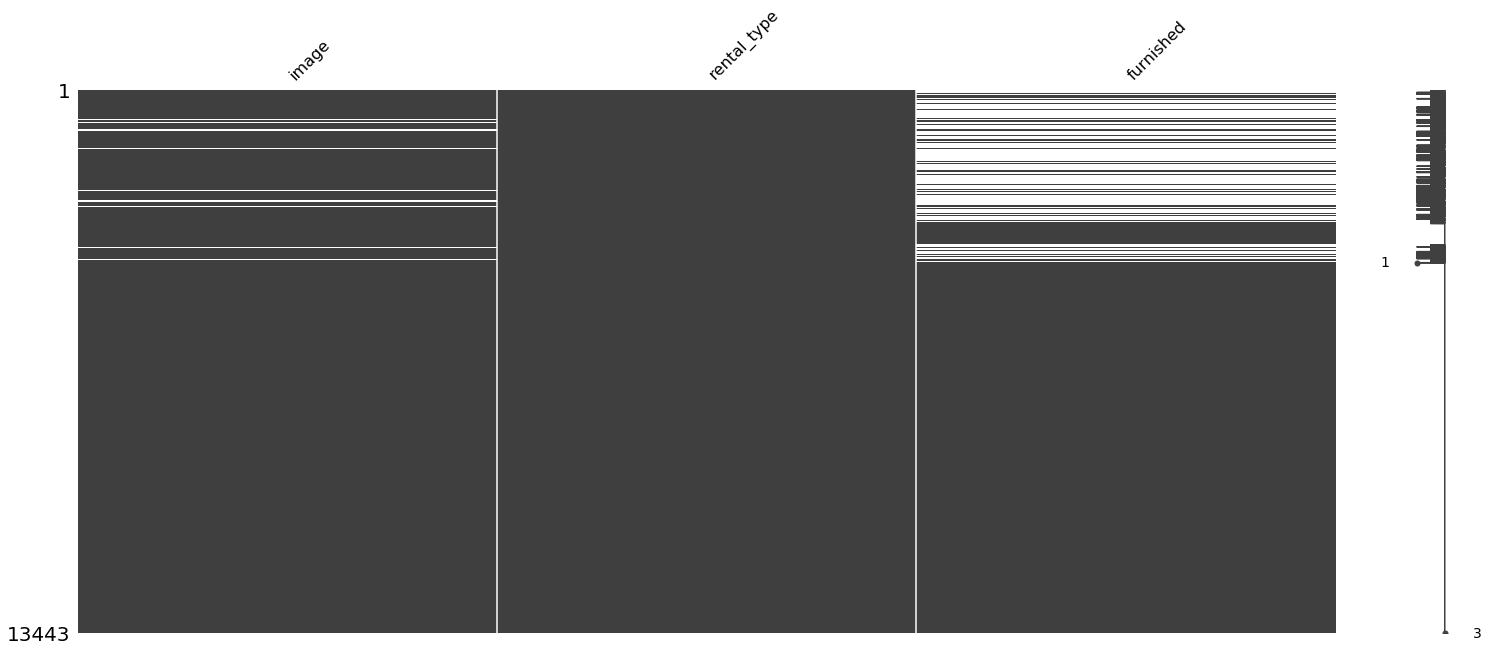

In [314]:
missingdata_col = DF.columns[DF.isnull().any()].tolist()
# import matplotlib
# import missingno as msno
%matplotlib inline
msno.matrix(DF[missingdata_col])

In [315]:
# def transform(DF):
df_rental = DF.copy()

In [316]:
def cleaning(DF):
    #Replace all white spaces or nothing at all to NaN
    DF.replace(r'^\s*$', np.nan, regex=True, inplace=True)
    #Replace None with NaN
    DF = DF.fillna(value=np.nan)
    #Typecast
    DF['price'] = DF['price'].astype('int') #Not required
    #Missing value handling
    DF['furnished'] = DF['furnished'].fillna(value="NOT_MENTIONED")
    DF['furnished'] = DF['furnished'].replace(to_replace=True, value='YES')
    DF['furnished'] = DF['furnished'].replace(to_replace=False, value='NO')
    #New features 
    DF['post_published_date'] = DF['post_published_date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    DF['posted_week_of_month'] = DF['post_published_date'].map(lambda x: x.day//7 +1)
    ##Convert image url to image or not? (New feature)
    DF['image'] = DF['image'].notna()
    return DF

In [317]:
DF_cleaned = cleaning(df_rental)

## Create Crime, CA, Age and Income Allignment with FSA

In [394]:
CA_records = list(client.ETLInsight["CommunityAssets"].find({}, {'_id':0}))
CA_DF = pd.DataFrame(CA_records)

In [395]:
CA_FSA_table = CA_DF.groupby(['fsa', 'category'])['category'].count().unstack().fillna(0).astype(int)
#Drop unspecified community service
CA_FSA_table.drop(columns=[''], inplace=True)

In [396]:
Crime_records = pd.read_csv(url_crimeCSV)
# CA_DF = pd.DataFrame(CA_records)

In [397]:
Crime_FSA_table = Crime_records[['FSA', 'MCI', 'Count of MCI']].groupby(['FSA', 'MCI']).sum().unstack().fillna(0).astype(int)
Crime_FSA_table.columns = Crime_FSA_table.columns.droplevel()
Crime_FSA_table.columns.name = None
Crime_FSA_table.drop(index="Overall", inplace=True)

In [398]:
Crime_CA_FSA = CA_FSA_table.join(Crime_FSA_table, how='outer').fillna(0).astype('int')

In [399]:
Age_Income_records = list(client.ETLInsight["FSAIncomeAge"].find({}, {'_id':0}))
Age_Income_DF = pd.DataFrame(Age_Income_records)

In [400]:
Age_Income_DF.set_index('FSA', inplace=True)

In [402]:
Crime_CA_Income_Age_FSA = Crime_CA_FSA.join(Age_Income_DF, how='left').fillna(0)

In [404]:
Crime_CA_Income_Age_FSA.reset_index(inplace=True)
Crime_CA_Income_Age_FSA.rename(columns={'index':'FSA'}, inplace=True)

In [405]:
#Push the Crime_CA_Income_Age_FSA into db
Crime_CA_Income_Age_FSA

,FSA,Community Services,Education & Employment,Financial Services,Food & Housing,Health Services,Law & Government,Transportation,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,avg_income,Avg_Age
0,M1B,13,5,3,4,7,1,0,1056,234,211,182,43,30679.49815,38.9
1,M1C,0,0,0,2,1,0,0,363,110,203,59,18,51018.70702,42.1
2,M1E,9,1,0,7,8,0,0,1683,139,336,239,26,36469.54721,41.5
3,M1G,2,2,0,1,2,0,0,659,63,112,111,14,27923.13760,38.6
4,M1H,8,4,1,5,17,2,0,664,106,182,161,33,31647.27366,39.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,M9N,10,2,0,1,4,1,0,715,256,228,149,28,33422.27414,39.3
94,M9P,0,4,0,6,1,0,0,219,140,167,45,23,50239.79406,44.9
95,M9R,2,0,0,2,4,1,0,536,217,184,106,17,37825.68842,40.9
96,M9V,15,4,1,8,5,1,0,1263,597,250,337,53,26914.85423,37.4


In [406]:
# client = MongoClient(db_connection_string)
# client.ETLInsight.CrimeCAIncomeAgeFSA.insert_many(Crime_CA_Income_Age_FSA.T.to_dict().values())
# client.close()

## Remove Outliers


In [407]:
def feasibilityCheck(row):
    #Check if prediction is feasible or not
    if (not row["FSA"]) or (not row["rental_type"]) or (row["FSA"]!=row["FSA"]) or (not re.search('^M', row["FSA"])):
        return False
    if row["sqft"]:
        if (row["sqft"]>3000) or (row["sqft"]<200):
            return False
    return True

In [408]:
feasibility = DF_cleaned.apply(lambda x: feasibilityCheck(x), axis=1)

In [409]:
DF_no_outlier = DF_cleaned[feasibility]

In [410]:
DF_no_outlier.shape
DF_cleaned.shape

(13153, 20)

(13443, 20)

## Combine the Rental with Crime , Community Assets, Income and Age info based on FSA

In [416]:
Crime_CA_Income_Age_FSA.set_index('FSA', inplace=True)

In [418]:
DF = DF_no_outlier.join(Crime_CA_Income_Age_FSA, on='FSA', how='left')

In [421]:
num_columns = ['sqft', 'bedrooms', 'bathrooms', 'posted_week_of_month', 'Community Services',
       'Education & Employment', 'Financial Services', 'Food & Housing',
       'Health Services', 'Law & Government', 'Transportation', 'Assault', 'Auto Theft',
              'Break and Enter','Robbery', 'Theft Over', 'Avg_Age', 'avg_income']
cat_columns = ['image', 'FSA', 'rental_type', 'furnished', 'pet_friendly']

In [422]:
X = DF[num_columns + cat_columns]

In [423]:
X

,sqft,bedrooms,bathrooms,posted_week_of_month,Community Services,Education & Employment,Financial Services,Food & Housing,Health Services,Law & Government,...,Break and Enter,Robbery,Theft Over,Avg_Age,avg_income,image,FSA,rental_type,furnished,pet_friendly
0,NaN,1.0,0.0,4,10,4,2,9,27,16,...,280,246,65,36.6,46121.43600,False,M5B,apartment,YES,False
1,NaN,1.0,0.0,4,7,0,1,14,16,1,...,481,147,123,43.6,120758.47890,False,M5R,condo,YES,False
2,1100.0,2.0,2.0,4,14,1,0,3,7,1,...,463,203,63,39.5,41532.98029,True,M6H,townhouse,NOT_MENTIONED,True
3,NaN,2.0,2.0,4,15,4,2,8,12,1,...,693,186,120,34.2,76540.54826,True,M5V,loft,NOT_MENTIONED,False
4,NaN,1.0,0.0,4,14,4,2,13,7,1,...,336,153,33,41.8,57558.07137,False,M6G,apartment,YES,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13438,NaN,1.0,1.0,2,15,4,2,8,12,1,...,693,186,120,34.2,76540.54826,True,M5V,condo,NOT_MENTIONED,False
13439,575.0,1.0,1.0,2,49,7,1,28,67,4,...,699,431,103,39.3,50511.19501,True,M5A,condo,NOT_MENTIONED,True
13440,NaN,0.0,1.0,2,6,1,0,1,3,1,...,142,44,29,40,89985.55241,True,M5E,condo,NOT_MENTIONED,True
13441,NaN,0.0,1.0,2,15,4,2,8,12,1,...,693,186,120,34.2,76540.54826,True,M5V,condo,NOT_MENTIONED,False
